In [1]:
import numpy as np
from sys import getsizeof
import matplotlib.pyplot as plt
from my_functions import FokkerPlankCalculator
from scipy.linalg import expm

In [2]:
#border = 0.002
dt = 0.002
k = 3
max_t = 2
#num_particle: 40000
tau = 0
D = 1e-6

dx = 0.00002
x_range = (-0.003,0.003)

N_x = int(round((x_range[1] - x_range[0])/dx))+1
N_t = int(round(max_t/dt))+1
R = np.zeros((N_t, N_x, N_x))
data = np.zeros((N_t, N_x))
x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)

In [3]:
data.shape

(1001, 301)

In [4]:
getsizeof(R)/1e6

725.532952

In [5]:
def get_D_w(D, max_t, dt, tau, k):
    my_fpc = FokkerPlankCalculator()
    s = np.sqrt(2*D)

    ts_all = np.arange(0, max_t+dt*5/4, dt/2)
    print(len(ts_all))
    ts = ts_all[::2]
    ts_ = ts_all[1::2]


    if tau > 0:
        max_p = int(max_t / tau) + 1
        print(max_p)
        l_data_all = my_fpc.l(k, tau, ts_all, max_p=max_p)
    else:
        l_data_all = np.exp(-k*ts_all)
    l_data = l_data_all[::2]
    l_data_ = l_data_all[1::2]

    w = my_fpc.get_w(l_data, l_data_, max_t)
    D_t_raw = my_fpc.get_D(l_data, l_data_, ts, max_t,D)
    return w, D_t_raw

In [6]:
w, D_t_raw = get_D_w(D, max_t, dt, tau, k)
D_t = 2*D_t_raw

2003


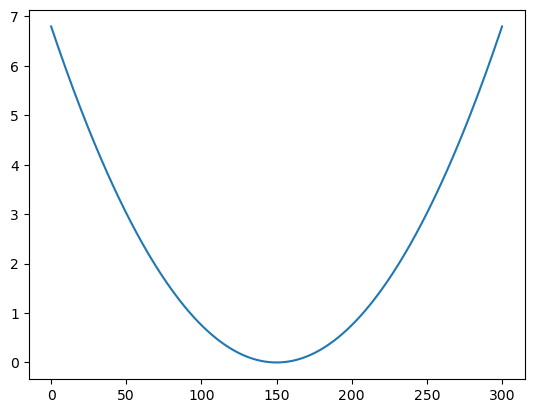

In [7]:
G = 0
U = (1/2*w[:,None]*x_s[None,:]**2 - G * x_s[None,:])/ D_t[:,None] 
plt.plot(U[0])

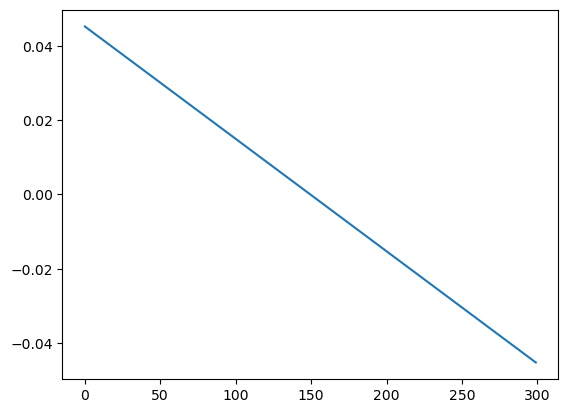

In [8]:
plt.plot(-(U[0,1:]-U[0,:-1])/2)

In [9]:
R[:,np.arange(1,301),np.arange(0,300)].shape

(1001, 300)

In [10]:
R[:,np.arange(1,301),np.arange(0,300)] = D_t[:,None] / dx**2 * np.exp(-(U[:,1:]-U[:,:-1])/2)
R[:,np.arange(0,300),np.arange(1,301)] = D_t[:,None] / dx**2 * np.exp((U[:,1:]-U[:,:-1])/2)
R.shape

(1001, 301, 301)

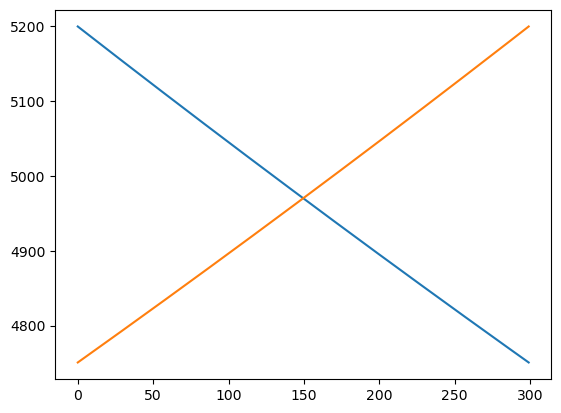

In [11]:
plt.plot(R[0,np.arange(1,301),np.arange(0,300)])
plt.plot(R[0,np.arange(0,300),np.arange(1,301)])

In [12]:
prop = np.stack([expm(o*dt) for o in R])

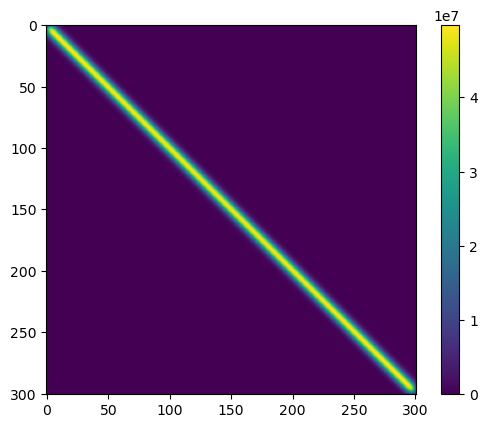

In [17]:
plt.imshow(prop[-1])
plt.colorbar()